## Подготавливаем данные и смотрим что вообще имеем

In [127]:
import chess
import pandas as pd
import numpy as np
pd.set_option("max_colwidth", 999)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [128]:
df = pd.read_csv('fens_training_set.csv')
df.head()

,fen,move
0,7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1,h5f3
1,5r2/2p3k1/1p3pb1/p1pPr2p/2P1PRP1/3B1R2/PP4K1/8 w - - 0 1,g4h5
2,r2r2k1/p3bpp1/q2Bp2p/2pn4/2b1N1Q1/8/PPP2PPP/3RR1K1 w - - 0 1,d6e7
3,8/8/8/7K/1k6/8/6P1/8 w - - 0 1,g2g4
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNBQ1RK1 w kq - 0 1,f1e1


In [129]:
board = chess.Board(df['fen'][0])

In [130]:
df['fen'][0]

'7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1'

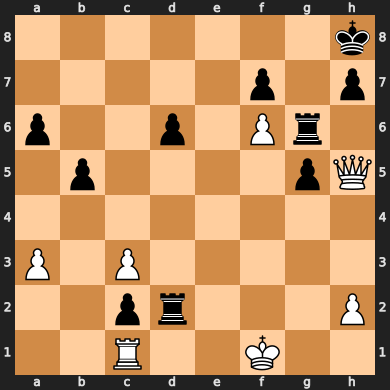

In [131]:
board

In [132]:
bad_string = []

In [133]:
for bd in df.index:
    curr_str = df.loc[bd]
    curr_board = chess.Board(curr_str['fen'])
    if curr_str['move'] not in list(map(str, curr_board.legal_moves)):
        bad_string.append(bd)

print(len(bad_string))


1


In [134]:
bad_string = bad_string[0]
board = chess.Board(df['fen'].loc[bad_string])
print(df['move'].loc[bad_string])

f1h1


In [135]:
df.drop(index=bad_string, inplace=True)

In [136]:
df.columns

Index(['fen', 'move'], dtype='object')

Подготовить все возможные ходы

In [137]:
board.has_kingside_castling_rights(chess.BLACK)

False

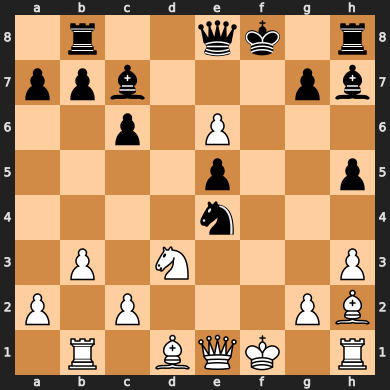

In [138]:
board

In [139]:
piece_to_plane = {
    (chess.PAWN, True):0, (chess.KNIGHT, True):1, (chess.BISHOP, True):2,
    (chess.ROOK, True):3, (chess.QUEEN, True):4, (chess.KING, True):5,
    (chess.PAWN, False):6, (chess.KNIGHT, False):7, (chess.BISHOP, False):8,
    (chess.ROOK, False):9, (chess.QUEEN, False):10, (chess.KING, False):11,
}


In [140]:
def board_to_tensor(board):
    planes = torch.zeros((19, 8, 8), dtype=torch.float32)
    # Слой - фигура определенного цвета
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            plane = piece_to_plane[(piece.piece_type, piece.color)]
            r = 7 - chess.square_rank(sq)
            c = chess.square_file(sq)
            planes[plane, r, c] = 1.0
    # чей ход
    if (board.turn == chess.WHITE):
        planes[12, :, :] = 1.0
    # Рокировки
    planes[13,:,:] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    planes[14,:,:] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    planes[15,:,:] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    planes[16,:,:] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    # Взятие
    if board.ep_square is not None:
        r = 7 - chess.square_rank(board.ep_square)
        c = chess.square_file(board.ep_square)
        planes[17, r, c] = 1.0
    # ШАХ!
    planes[18, :, :] = 1.0 if board.is_check() else 0.0
    return planes


In [141]:
def index_to_move(idx):
    promo = int(idx%5)
    tmp = int(idx//5)
    frm = tmp//64
    to = int(tmp%64)
    if promo == 0:
        return chess.Move(frm, to)
    else:
        promo_piece = {1 : chess.QUEEN, 2 : chess.ROOK, 3 : chess.BISHOP, 4 : chess.KNIGHT}[promo]
        return chess.Move(frm, to, promotion=promo_piece)

In [142]:
promo_map = {'q' : 1, 'r' : 2, 'b' : 3, 'n': 4}

def move_to_index(move):
    frm = move.from_square
    to = move.to_square
    promo = 0
    if (move.promotion):
        promo = promo_map[chess.piece_symbol(move.promotion).lower()]
        if move.promotion == chess.QUEEN : promo = 1
        elif move.promotion == chess.ROOK : promo = 2
        elif move.promotion == chess.BISHOP : promo = 3
        elif move.promotion == chess.KNIGHT: promo = 4
    return frm * 64 * 5 + to * 5 + promo

def legal_mask(board):
    mask = torch.zeros(64*64*5, dtype=torch.bool)
    for mv in board.legal_moves:
        idx = move_to_index(mv)
        mask[idx] = True
    mask = mask.to(device=device)
    return mask

In [143]:
for i in board.legal_moves:
    print(move_to_index(i))
    break

6260


In [144]:
df.reset_index(drop=True)
df.head()

,fen,move
0,7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1,h5f3
1,5r2/2p3k1/1p3pb1/p1pPr2p/2P1PRP1/3B1R2/PP4K1/8 w - - 0 1,g4h5
2,r2r2k1/p3bpp1/q2Bp2p/2pn4/2b1N1Q1/8/PPP2PPP/3RR1K1 w - - 0 1,d6e7
3,8/8/8/7K/1k6/8/6P1/8 w - - 0 1,g2g4
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNBQ1RK1 w kq - 0 1,f1e1


## Создаю датасет

In [165]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.transforms import v2
V = 64*64*5
class ChessDataset(Dataset):
    def __init__(self, df, board_to_tensor, move_to_index):
        self.data = df.reset_index(drop=True)
        self.board_to_tensor = board_to_tensor
        self.move_to_index = move_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        fen = row['fen']
        uci = row['move']
        board = chess.Board(fen)
        planes = board_to_tensor(board)
        mv = chess.Move.from_uci(uci)
        target_idx = int(self.move_to_index(mv))
        legal_idx = np.fromiter((move_to_index(mv) for mv in board.legal_moves), dtype=np.int32)
        return planes, target_idx, legal_idx

In [166]:
ds = ChessDataset(df.head(10), board_to_tensor, move_to_index)
print(len(ds))
print(ds[0][0].shape, ds[0][1], ds[0][2].shape)  # planes.shape, target_idx, legal_idxs.shape


10
torch.Size([19, 8, 8]) 12585 (21,)


In [167]:
def collate_build_mask(batch):
    B = len(batch)
    C = batch[0][0].shape
    planes_np = np.stack([item[0] for item in batch], axis=0, dtype=np.float32)
    targets = torch.tensor([int(item[1]) for item in batch], dtype=torch.int64)
    rows = []
    cols = []
    for i, item in enumerate(batch):
        idxs = item[2]
        rows.append(np.full(idxs.shape[0], i, dtype=np.int64))
        cols.append(idxs.astype(np.int64))
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    legal_mask = torch.zeros((B, V), dtype=torch.bool)
    legal_mask[torch.from_numpy(rows), torch.from_numpy(cols)] = True
    planes_torch = torch.from_numpy(planes_np)
    return planes_torch, targets, legal_mask


## Модель: простой resnet + маска

In [168]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
BIG_NEG = -10e9
class ChessModel(nn.Module):
    def __init__(self, in_channels=19, hidden =64, n_blocks=2, out=V):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32)
        self.bn_in = nn.BatchNorm2d(hidden)
        self.relu = nn.ReLU(inplace=True)
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            self.blocks.append(nn.Sequential(
                nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32),
                nn.BatchNorm2d(hidden),
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32),
                nn.BatchNorm2d(hidden)
            ))
        self.conv_head = nn.Conv2d(hidden, 64, kernel_size=1, dtype=torch.float32)
        self.dropout = nn.Dropout(0.35)
        self.fc = nn.Linear(64*8*8, out)

    def forward(self, x):
        # x : (B, C, 8, 8)
        x = self.relu(self.bn_in(self.conv_in(x)))
        for blk in self.blocks:
            res = x
            out = blk(x)
            x = self.relu(out + res)
        x = self.relu(self.conv_head(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits


### 20 эпох, метрики: top1, top3

In [169]:
EPOCH = 20
train_loss = []
val_loss = []
val_acc = []
train_acc = []
val_top3_acc_list = []
from tqdm import tqdm
best_top3_acc = 0.0
mean_val_loss = 0
BEST_MODEL_PATH = '.'
ds = ChessDataset(df, board_to_tensor, move_to_index)
train, test_set = random_split(ds, [0.7, 0.3])
train_set, val_set = random_split(train, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_build_mask, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_build_mask, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_build_mask, drop_last=True, pin_memory=True)
model = ChessModel().to(device)
opt = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [ ]:

for epoch in range(EPOCH):
    running_train_loss = []
    model.train()
    true_answer = 0
    train_loop = tqdm(train_loader, leave=False)
    for planes, targets, legal_mask in train_loop:
        planes = planes.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True)
        legal_mask = legal_mask.to(device, non_blocking=True)

        logits = model(planes)
        masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)



        loss = F.cross_entropy(masked_logits, targets)
        opt.zero_grad()
        loss.backward()
        opt.step()


        running_train_loss.append(loss.item())
        true_answer += (masked_logits.argmax(dim=1) == targets).sum().item()
        mean_train_loss = np.sum(running_train_loss)/len(running_train_loss)
        train_loop.set_description(f'epoch {epoch + 1}/{EPOCH}, train_loss={mean_train_loss}')

    running_train_acc = true_answer/len(train_set)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    correct_top3_val = 0
    model.eval()
    val_loop = tqdm(val_loader, leave=False)
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for planes, targets, legal_mask in val_loop:

            planes = planes.to(device, non_blocking=True).float()
            targets = targets.to(device, non_blocking=True)
            legal_mask = legal_mask.to(device, non_blocking=True)

            logits = model(planes)
            masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)

            loss = F.cross_entropy(masked_logits, targets)
            running_val_loss.append(loss.item())

            top3_pred = masked_logits.topk(3, dim=1).indices  # (B, 3)
            correct_top3 = (top3_pred == targets.unsqueeze(1)).any(dim=1)
            correct_top3_val += correct_top3.sum().item()

            true_answer += (masked_logits.argmax(dim=1) == targets).sum().item()
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            val_loop.set_description(f'epoch {epoch + 1}/{EPOCH}, val_loss={mean_val_loss}')
    running_val_acc = true_answer/len(val_set)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    val_top3_acc_epoch = correct_top3_val / len(val_set)
    val_top3_acc_list.append(val_top3_acc_epoch)
    if val_top3_acc_epoch > best_top3_acc:
        best_top3_acc = val_top3_acc_epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'top3_acc': best_top3_acc,
            'loss': mean_val_loss,
        }, f'/home/nomad/Downloads/mainpy/test_chess/model_{epoch}.pth')
    print(f'EPOCH [{epoch+1}/{EPOCH}] | '
          f'Train Loss: {mean_train_loss:.4f}, Train Acc: {running_train_acc:.4f}, | '
          f'Val Loss: {mean_val_loss:.4f}, Val Acc: {running_val_acc:.4f}, Val Top-3: {val_top3_acc_epoch:.4f}')
torch.save({
            'epoch': -1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'top3_acc': best_top3_acc,
            'loss': mean_val_loss,
        }, f'/home/nomad/Downloads/mainpy/test_chess/model_{-1}.pth')

EPOCH [1/20] | Train Loss: 2.7047, Train Acc: 0.2235, | Val Loss: 2.5336, Val Acc: 0.2669, Val Top-3: 0.4838


EPOCH [2/20] | Train Loss: 2.2610, Train Acc: 0.3274, | Val Loss: 2.4506, Val Acc: 0.2942, Val Top-3: 0.5178


EPOCH [3/20] | Train Loss: 1.7928, Train Acc: 0.4529, | Val Loss: 2.5705, Val Acc: 0.2980, Val Top-3: 0.5306


EPOCH [4/20] | Train Loss: 1.4064, Train Acc: 0.5649, | Val Loss: 2.7149, Val Acc: 0.2980, Val Top-3: 0.5264


EPOCH [5/20] | Train Loss: 1.1530, Train Acc: 0.6402, | Val Loss: 2.9198, Val Acc: 0.2978, Val Top-3: 0.5276


EPOCH [6/20] | Train Loss: 0.9751, Train Acc: 0.6927, | Val Loss: 3.1880, Val Acc: 0.2959, Val Top-3: 0.5209


EPOCH [7/20] | Train Loss: 0.8533, Train Acc: 0.7289, | Val Loss: 3.3945, Val Acc: 0.2944, Val Top-3: 0.5174


EPOCH [8/20] | Train Loss: 0.7609, Train Acc: 0.7557, | Val Loss: 3.5789, Val Acc: 0.2933, Val Top-3: 0.5157


EPOCH [9/20] | Train Loss: 0.6896, Train Acc: 0.7773, | Val Loss: 3.8579, Val Acc: 0.2939, Val Top-3: 0.5158


EPOCH [10/20] | Train Loss: 0.6320, Train Acc: 0.7951, | Val Loss: 3.9618, Val Acc: 0.2919, Val Top-3: 0.5136


EPOCH [11/20] | Train Loss: 0.5885, Train Acc: 0.8075, | Val Loss: 4.1423, Val Acc: 0.2899, Val Top-3: 0.5140


EPOCH [12/20] | Train Loss: 0.5547, Train Acc: 0.8172, | Val Loss: 4.4139, Val Acc: 0.2910, Val Top-3: 0.5105


EPOCH [13/20] | Train Loss: 0.5241, Train Acc: 0.8281, | Val Loss: 4.4876, Val Acc: 0.2907, Val Top-3: 0.5142


EPOCH [14/20] | Train Loss: 0.4947, Train Acc: 0.8365, | Val Loss: 4.5283, Val Acc: 0.2906, Val Top-3: 0.5115


EPOCH [15/20] | Train Loss: 0.4754, Train Acc: 0.8422, | Val Loss: 4.6583, Val Acc: 0.2915, Val Top-3: 0.5126


EPOCH [16/20] | Train Loss: 0.4548, Train Acc: 0.8491, | Val Loss: 4.7517, Val Acc: 0.2922, Val Top-3: 0.5142


EPOCH [17/20] | Train Loss: 0.4399, Train Acc: 0.8540, | Val Loss: 4.9471, Val Acc: 0.2904, Val Top-3: 0.5126


EPOCH [18/20] | Train Loss: 0.4235, Train Acc: 0.8577, | Val Loss: 4.8670, Val Acc: 0.2865, Val Top-3: 0.5086


EPOCH [19/20] | Train Loss: 0.4092, Train Acc: 0.8620, | Val Loss: 5.0088, Val Acc: 0.2893, Val Top-3: 0.5136


EPOCH [20/20] | Train Loss: 0.3972, Train Acc: 0.8662, | Val Loss: 5.1561, Val Acc: 0.2887, Val Top-3: 0.5118


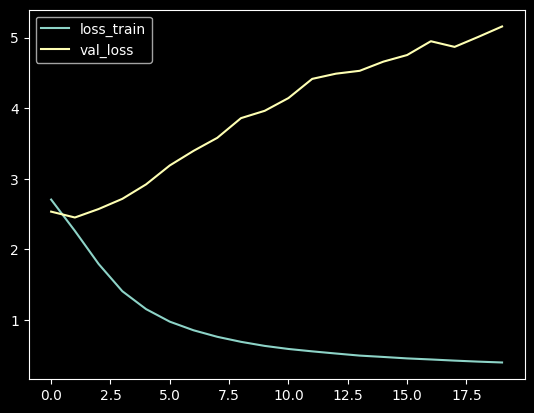

In [171]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'val_loss'])
plt.show()

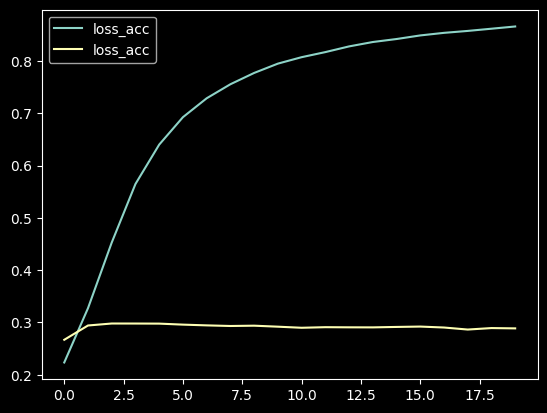

In [172]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['loss_acc', 'loss_acc'])
plt.show()

In [221]:
checkpoint = torch.load("model_2.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

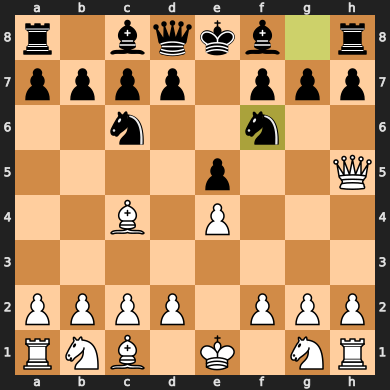

In [222]:
import chess

board = chess.Board()

board.legal_moves
board.push_san("e4")
board.push_san("e5")
board.push_san("Qh5")
board.push_san("Nc6")
board.push_san("Bc4")
board.push_san("Nf6")
board

In [ ]:
model.to(device)
mv = board.parse_san("Qxf7")
new_df = pd.DataFrame({'fen' : [board.fen()], 'move' : [str(mv)]})

In [225]:
model.eval()
with torch.no_grad():
    new_ds = ChessDataset(new_df, board_to_tensor, move_to_index)
    new_dl = DataLoader(new_ds, batch_size=1, collate_fn=collate_build_mask)
    for planes, targets, legal_mask in new_dl:
        planes = planes.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True)
        legal_mask = legal_mask.to(device, non_blocking=True)

        logits = model(planes)
        masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)
        print(masked_logits.argmax(dim=1))

tensor([410], device='cuda:0')


In [226]:
index_to_move(410)

Move.from_uci('b1c3')

In [227]:
board.push(chess.Move.from_uci('b1c3'))

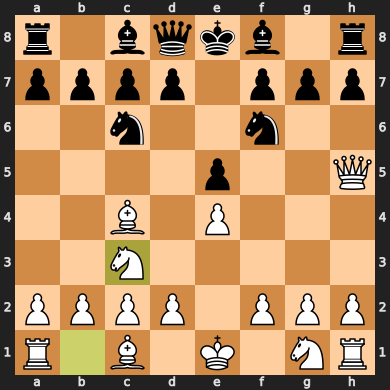

In [228]:
board

In [229]:
test_loop = tqdm(test_loader, leave=False)
running_test_loss = []
correct_top1 = 0
correct_top3 = 0
total = 0
model.eval()
with torch.no_grad():
    for planes, targets, legal_mask in test_loop:
        planes = planes.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True)
        legal_mask = legal_mask.to(device, non_blocking=True)

        logits = model(planes)
        masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)

        loss = F.cross_entropy(masked_logits, targets)
        running_test_loss.append(loss.item())

        preds = masked_logits.argmax(dim=1)
        correct_top1 += (preds == targets).sum().item()

        # Top-3
        top3_pred = masked_logits.topk(3, dim=1).indices
        correct_top3 += (top3_pred == targets.unsqueeze(1)).any(dim=1).sum().item()

        total += targets.size(0)

mean_test_loss = sum(running_test_loss) / len(running_test_loss)
test_acc_top1 = correct_top1 / total
test_acc_top3 = correct_top3 / total

print(f"Test Loss: {mean_test_loss:.4f}")
print(f"Test Top-1 Accuracy: {test_acc_top1:.4f}")
print(f"Test Top-3 Accuracy: {test_acc_top3:.4f}")

  0%|          | 0/2517 [00:00<?, ?it/s]

Test Loss: 2.5709
Test Top-1 Accuracy: 0.2989
Test Top-3 Accuracy: 0.5260
